# Import

In [1]:
!pip install git+https://github.com/cvg/LightGlue.git

  Cloning https://github.com/cvg/LightGlue.git to /tmp/pip-req-build-pj3zb6xo
  Running command git clone --filter=blob:none --quiet https://github.com/cvg/LightGlue.git /tmp/pip-req-build-pj3zb6xo
  Resolved https://github.com/cvg/LightGlue.git to commit edb2b838efb2ecfe3f88097c5fad9887d95aedad
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for lightglue: filename=lightglue-0.0-py3-none-any.whl size=39499 sha256=f5525d216bec4de240f96292bf35146052b62ab8621b381efb8c2ae8758954e6
  Stored in directory: /tmp/pip-ephem-wheel-cache-0pl9vgcc/wheels/07/dc/a1/22bc17d3d78e58fbd145e264d6736aab70959fbf872c80ddb9
Successfully built lightglue


In [2]:
import cv2
import torch
from lightglue import ALIKED
from lightglue.utils import load_image, rbd

from transformers import AutoImageProcessor, AutoModel
from PIL import Image

import kornia as K
import kornia.feature as KF

2024-04-30 05:38:41.689303: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 05:38:41.689489: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 05:38:41.862197: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# ALIKED

In [4]:
aliked = ALIKED(max_num_keypoints=4096, detection_threshold=0.01).eval().to(device)

image0 = load_image('/kaggle/input/image-matching-challenge-2024/train/church/images/00001.png').to(device)

# extract local features
feats0 = aliked.extract(image0)  # auto-resize the image, disable with resize=None
for k, v in feats0.items():
    print (k, v.shape)

Downloading: "https://github.com/Shiaoming/ALIKED/raw/main/models/aliked-n16.pth" to /root/.cache/torch/hub/checkpoints/aliked-n16.pth
100%|██████████| 2.61M/2.61M [00:00<00:00, 74.2MB/s]


keypoints torch.Size([1, 4096, 2])
descriptors torch.Size([1, 4096, 128])
keypoint_scores torch.Size([1, 4096])
image_size torch.Size([1, 2])


In [5]:
feats0.items()

dict_items([('keypoints', tensor([[[557.9164, 495.9955],
         [512.8110, 505.9701],
         [534.5049, 501.1361],
         ...,
         [212.1918, 397.0319],
         [399.1904, 548.9808],
         [343.1084, 544.9963]]])), ('descriptors', tensor([[[-0.0153,  0.0267, -0.0703,  ...,  0.0943, -0.0142,  0.0646],
         [-0.0471, -0.1022, -0.0973,  ..., -0.1469, -0.0399,  0.0732],
         [ 0.0421, -0.0295, -0.0579,  ..., -0.0784,  0.0575,  0.0970],
         ...,
         [-0.0954,  0.1053,  0.1499,  ...,  0.1125, -0.0368,  0.0169],
         [ 0.0305,  0.0350,  0.0015,  ...,  0.0648,  0.0072,  0.0693],
         [ 0.0123, -0.0669,  0.1066,  ...,  0.0018,  0.1133, -0.0348]]])), ('keypoint_scores', tensor([[0.0492, 0.0660, 0.0957,  ..., 1.0013, 0.9241, 0.8969]])), ('image_size', tensor([[1024.,  768.]]))])

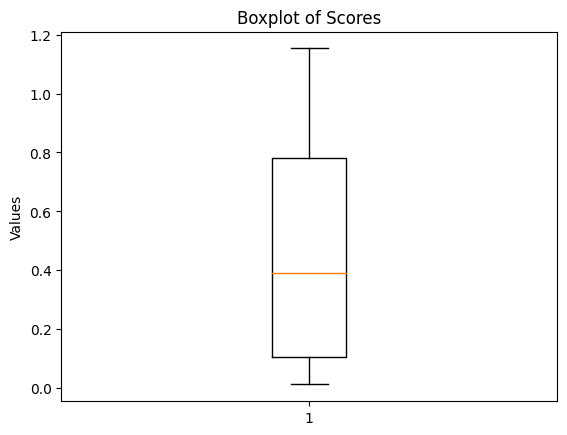

In [6]:
import matplotlib.pyplot as plt

# 박스플롯 그리기
plt.boxplot(feats0['keypoint_scores'])

# 그래프에 제목 추가
plt.title('Boxplot of Scores')

# y축 레이블 추가
plt.ylabel('Values')

# 그래프 보여주기
plt.show()

# DINO

In [7]:
image = Image.open("/kaggle/input/image-matching-challenge-2024/train/church/images/00001.png")

processor = AutoImageProcessor.from_pretrained('/kaggle/input/dinov2/pytorch/base/1')
model = AutoModel.from_pretrained('/kaggle/input/dinov2/pytorch/base/1')

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [8]:
image2 = Image.open("/kaggle/input/image-matching-challenge-2024/train/church/images/00002.png")
inputs2 = processor(images=image2, return_tensors="pt")
outputs2 = model(**inputs2)
last_hidden_states2 = outputs2.last_hidden_state
last_hidden_states2.shape

torch.Size([1, 257, 768])

In [9]:
torch.dist(last_hidden_states, last_hidden_states2)

tensor(877.7618, grad_fn=<DistBackward0>)

# LightGlue(disk)

In [10]:
fname1 = "/kaggle/input/image-matching-challenge-2024/train/church/images/00001.png"
fname2 = "/kaggle/input/image-matching-challenge-2024/train/church/images/00002.png"

lg_matcher = KF.LightGlueMatcher("disk").eval().to(device)

img1 = K.io.load_image(fname1, K.io.ImageLoadType.RGB32, device=device)[None, ...]
img2 = K.io.load_image(fname2, K.io.ImageLoadType.RGB32, device=device)[None, ...]

num_features = 2048
disk = KF.DISK.from_pretrained("depth").to(device)
hw1 = torch.tensor(img1.shape[2:], device=device)
hw2 = torch.tensor(img2.shape[2:], device=device)

with torch.inference_mode():
    inp = torch.cat([img1, img2], dim=0)
    features1, features2 = disk(inp, num_features, pad_if_not_divisible=True)
    kps1, descs1 = features1.keypoints, features1.descriptors
    kps2, descs2 = features2.keypoints, features2.descriptors
    lafs1 = KF.laf_from_center_scale_ori(kps1[None])
    lafs2 = KF.laf_from_center_scale_ori(kps2[None])
    dists, idxs = lg_matcher(descs1, descs2, lafs1, lafs2, hw1=hw1, hw2=hw2)

print(f"{idxs.shape[0]} tentative matches with DISK LightGlue")

Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/disk_lightglue.pth" to /root/.cache/torch/hub/checkpoints/disk_lightglue_v0-1_arxiv-pth
100%|██████████| 45.4M/45.4M [00:00<00:00, 226MB/s]
Downloading: "https://raw.githubusercontent.com/cvlab-epfl/disk/master/depth-save.pth" to /root/.cache/torch/hub/checkpoints/depth-save.pth


Loaded LightGlue model


100%|██████████| 4.17M/4.17M [00:00<00:00, 122MB/s]
/opt/conda/lib/python3.10/site-packages/kornia/feature/integrated.py:464: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hw1_ = torch.tensor(hw1, device=dev)
/opt/conda/lib/python3.10/site-packages/kornia/feature/integrated.py:468: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hw2_ = torch.tensor(hw2, device=dev)


836 tentative matches with DISK LightGlue


# Lightglue(Aliked)

In [11]:
fname1 = "/kaggle/input/image-matching-challenge-2024/train/church/images/00001.png"
fname2 = "/kaggle/input/image-matching-challenge-2024/train/church/images/00002.png"

lg_matcher = KF.LightGlueMatcher("aliked").eval().to(device)

img1 = K.io.load_image(fname1, K.io.ImageLoadType.RGB32, device=device)[None, ...]
img2 = K.io.load_image(fname2, K.io.ImageLoadType.RGB32, device=device)[None, ...]

hw1 = torch.tensor(img1.shape[2:], device=device)
hw2 = torch.tensor(img2.shape[2:], device=device)

with torch.inference_mode():
    features1, features2 = aliked.extract(img1), aliked.extract(img2)
    kps1, descs1 = features1["keypoints"][0], features1["descriptors"][0]
    kps2, descs2 = features2["keypoints"][0], features2["descriptors"][0]
    lafs1 = KF.laf_from_center_scale_ori(kps1[None])
    lafs2 = KF.laf_from_center_scale_ori(kps2[None])
    dists, idxs = lg_matcher(descs1, descs2, lafs1, lafs2, hw1=hw1, hw2=hw2)

print(f"{idxs.shape[0]} tentative matches with DISK LightGlue")

Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/aliked_lightglue.pth" to /root/.cache/torch/hub/checkpoints/aliked_lightglue_v0-1_arxiv-pth
100%|██████████| 45.4M/45.4M [00:00<00:00, 243MB/s]


Loaded LightGlue model
1033 tentative matches with DISK LightGlue
